# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import cv2 as cv
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import torch
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

# Loading Dataset

In [284]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
def unzip_data(filename, loc = "Asg6"):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall(loc)
  zip_ref.close()

In [286]:
unzip_data('/content/drive/MyDrive/Colab Notebooks/data/Doodle.zip')

In [4]:
def load(container_path): # to load images files
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() ]
    categories = [fo.name for fo in folders]
    cat = []
    for i in folders:
      data = np.load(i)
      cat.append(data)
    print(categories)
    print(folders)

    return folders, categories, cat

In [5]:
class Part1:
  def __init__(self, loc):
    self.folders, self.categories, self.cat = load(loc)
    self.x = []
    for i in self.categories:
      i = i.split("_")
      self.x.append(i[3].rstrip(".npy"))
    self.categories = self.x

    self.data = []
    for a in self.cat:
      sub_data = []
      for b in a:
        b = np.reshape(b, (-1, 28))
        sub_data.append(b)
      self.data.append(np.array(sub_data)[:1000]) # 1000 images from each categories

    self.data = np.array(self.data)
    for j,k in enumerate(self.data):
      print(self.categories[j],"\t- ",len(k),"images and dim 28X28")

    self.train = [x for i in self.data for x in i]
    self.label = []
    for i,j in enumerate(self.data):
      l = np.zeros(len(j)) + i
      self.label.extend(l)

    self.train = np.array(self.train)
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.train, self.label, test_size=0.33, random_state=42)

In [6]:
p1 = Part1("/content/Asg6/Asg6")

['full_numpy_bitmap_car.npy', 'full_numpy_bitmap_bus.npy', 'full_numpy_bitmap_bicycle.npy', 'full_numpy_bitmap_truck.npy', 'full_numpy_bitmap_aircraft carrier.npy']
[PosixPath('/content/Asg6/Asg6/full_numpy_bitmap_car.npy'), PosixPath('/content/Asg6/Asg6/full_numpy_bitmap_bus.npy'), PosixPath('/content/Asg6/Asg6/full_numpy_bitmap_bicycle.npy'), PosixPath('/content/Asg6/Asg6/full_numpy_bitmap_truck.npy'), PosixPath('/content/Asg6/Asg6/full_numpy_bitmap_aircraft carrier.npy')]
car 	-  1000 images and dim 28X28
bus 	-  1000 images and dim 28X28
bicycle 	-  1000 images and dim 28X28
truck 	-  1000 images and dim 28X28
aircraft carrier 	-  1000 images and dim 28X28


In [7]:
cat = ['Car',
       'Bus',
       'Biycle',
       'Truck',
       'Aircraft']

In [8]:
trainX = np.array(p1.x_train)
trainy = np.array(p1.y_train)
testX =  np.array(p1.x_test)
testy =  np.array(p1.y_test)

In [9]:
trainX.shape, trainy.shape

((3350, 28, 28), (3350,))

Training data shapes: X=(3350, 28, 28), y=(3350,)
Testing data shapes: X=(1650, 28, 28), y=(1650,)


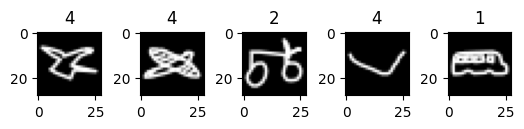

In [10]:
print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))

for j in range(5):
    i = np.random.randint(0, 3350)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(int(trainy[i]))
plt.show()

In [11]:
cls = pd.Series(trainy)
cls.min(), cls.max()

(0.0, 4.0)

There are five classes labled from 0 to 4

# **Part1**

Task 1: Learn to generate a doodle given an input vector (encoding) of 5 dimensions. Are 5 dimensions enough to produce good-quality doodles? If not, increase the dimensionality till you get good re-constructions. Using TSNE, visualize your dataset and explain the clusters produced.

# Data Preparation

In [12]:
train_data = trainX.astype('float32')/255
test_data = testX.astype('float32')/255

train_data = np.reshape(train_data, (3350, 28, 28, 1))
test_data = np.reshape(test_data, (1650, 28, 28, 1))

print (train_data.shape, test_data.shape)

(3350, 28, 28, 1) (1650, 28, 28, 1)


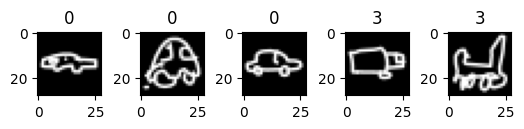

In [13]:
for j in range(5):
    i = np.random.randint(0, 3350)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(int(trainy[i]))
plt.show()

In [14]:
testing = list(zip(test_data, testy))

In [15]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=28, num_workers=0)
test_loader = torch.utils.data.DataLoader(testing, batch_size=28, num_workers=0)

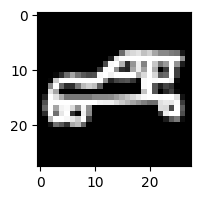

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
# obtain one batch of training images
dataiter = iter(train_loader)
print(dataiter)
images = next(dataiter)
images = images.numpy()
# get one image from the batch
img = np.squeeze(images[0])
fig = plt.figure(figsize = (2,2))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# Autoencoders

## with 9 encodings

In [45]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 9)
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 28 * 28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [58]:
# Model Initialization
model = AE()
# print(model.summary())

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.001,
                             weight_decay = 1e-8)

In [59]:
epochs = 1000
outputs = []
losses = []
epoch_loss = []
for epoch in range(epochs):
    ep_loss = 0
    for image in train_loader:

      # Reshaping the image to (-1, 784)
      image = image.reshape(-1, 28*28)

      # Output of Autoencoder
      reconstructed = model(image)

      # Calculating the loss function
      loss = loss_function(reconstructed, image)

      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Storing the losses in a list for plotting
      ep_loss += loss.item()
      losses.append(loss.item())
    epoch_loss.append(ep_loss)
    print("epoch : {}/{}, loss : {}".format(epoch, epochs, ep_loss))
    outputs.append((epochs, image, reconstructed))

epoch : 0/1000, loss : 10.473628096282482
epoch : 1/1000, loss : 8.880876876413822
epoch : 2/1000, loss : 8.335269559174776
epoch : 3/1000, loss : 7.9936488680541515
epoch : 4/1000, loss : 7.627577818930149
epoch : 5/1000, loss : 7.499581728130579
epoch : 6/1000, loss : 7.42190545797348
epoch : 7/1000, loss : 7.375157877802849
epoch : 8/1000, loss : 7.328492145985365
epoch : 9/1000, loss : 7.262644447386265
epoch : 10/1000, loss : 7.197193626314402
epoch : 11/1000, loss : 7.160553559660912
epoch : 12/1000, loss : 7.124948009848595
epoch : 13/1000, loss : 7.0685433857142925
epoch : 14/1000, loss : 7.008247401565313
epoch : 15/1000, loss : 6.920515213161707
epoch : 16/1000, loss : 6.813243489712477
epoch : 17/1000, loss : 6.729348927736282
epoch : 18/1000, loss : 6.667308799922466
epoch : 19/1000, loss : 6.614650044590235
epoch : 20/1000, loss : 6.581879127770662
epoch : 21/1000, loss : 6.511985864490271
epoch : 22/1000, loss : 6.473208285868168
epoch : 23/1000, loss : 6.453664485365152


KeyboardInterrupt: ignored

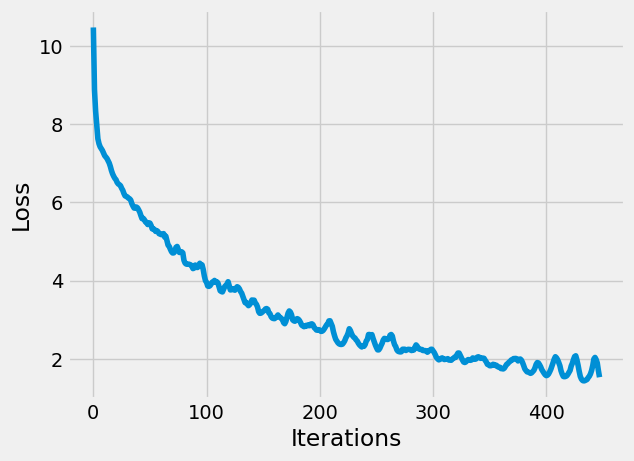

In [60]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
# Plotting the last 100 values
plt.plot(epoch_loss)

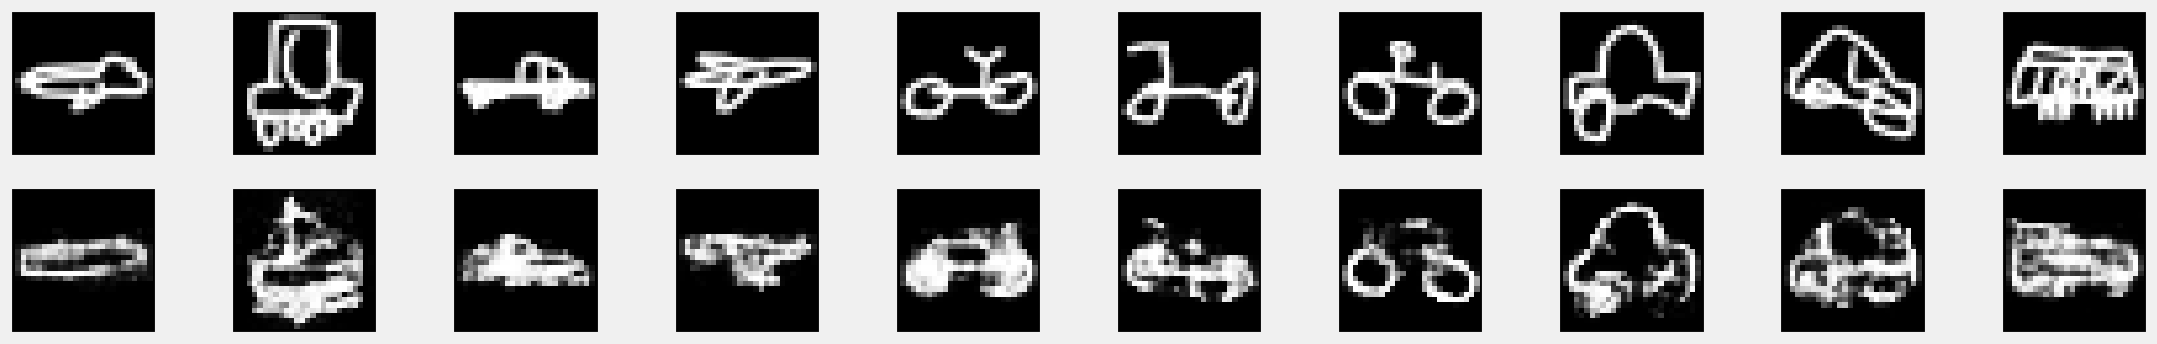

In [61]:
# obtain one batch of test images
dataiter = iter(test_loader)
images = next(dataiter)
images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()
# output is resized into a batch of images
output = output.view(28, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## with 3 encodings

In [353]:
# Creating a PyTorch class
class AE2(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 1024*3),
            torch.nn.ReLU(),
            torch.nn.Linear(1024*3, 512*2),
            torch.nn.ReLU(),
            torch.nn.Linear(512*2, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3)
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 28 * 28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [354]:
# Model Initialization
model2 = AE2()
# print(model.summary())

# Validation using MSE Loss function
loss_function = torch.nn.L1Loss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model2.parameters(),
                             lr = 0.01,
                             weight_decay = 1e-6)

In [ ]:
epochs = 150
outputs = []
losses = []
epoch_loss = []
for epoch in range(epochs):
    ep_loss = 0
    for image in train_loader:

      # Reshaping the image to (-1, 784)
      image = image.reshape(-1, 28*28)

      # Output of Autoencoder
      reconstructed = model2(image)

      # Calculating the loss function
      loss = loss_function(reconstructed, image)

      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Storing the losses in a list for plotting
      ep_loss += loss.item()
      losses.append(loss.item())
    epoch_loss.append(ep_loss)
    print("epoch : {}/{}, loss : {}".format(epoch, epochs, ep_loss))
    outputs.append((epochs, image, reconstructed))

epoch : 0/150, loss : 21.952838957309723
epoch : 1/150, loss : 21.49805136024952
epoch : 2/150, loss : 21.62474851310253
epoch : 3/150, loss : 21.519509568810463
epoch : 4/150, loss : 22.19026455283165
epoch : 5/150, loss : 23.32390584051609
epoch : 6/150, loss : 23.164886504411697
epoch : 7/150, loss : 23.110138326883316
epoch : 8/150, loss : 22.8781967908144
epoch : 9/150, loss : 22.925390288233757
epoch : 10/150, loss : 23.03432908654213
epoch : 11/150, loss : 23.08498179912567
epoch : 12/150, loss : 23.072385743260384
epoch : 13/150, loss : 23.190347403287888
epoch : 14/150, loss : 23.009343042969704
epoch : 15/150, loss : 22.519026562571526
epoch : 16/150, loss : 22.572342559695244
epoch : 17/150, loss : 22.477456972002983
epoch : 18/150, loss : 22.08521817624569
epoch : 19/150, loss : 21.853427052497864
epoch : 20/150, loss : 21.782382652163506
epoch : 21/150, loss : 21.680014565587044
epoch : 22/150, loss : 21.509329617023468
epoch : 23/150, loss : 21.495275244116783
epoch : 24/

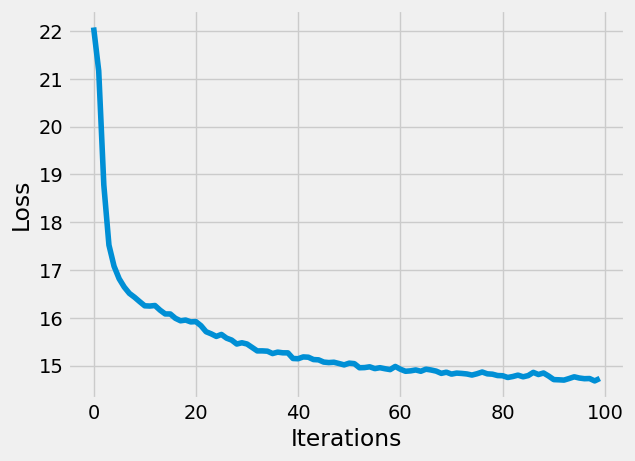

In [292]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
# Plotting the last 100 values
plt.plot(epoch_loss)

In [350]:
testy.shape

(1650,)

In [351]:
# obtain one batch of test images
dataiter = iter(test_loader)

tensor([1., 2., 2., 1., 0., 0., 0., 2., 2., 1., 2., 0., 0., 0., 3., 3., 1., 3.,
        1., 1., 0., 3., 1., 0., 4., 0., 4., 0.], dtype=torch.float64)


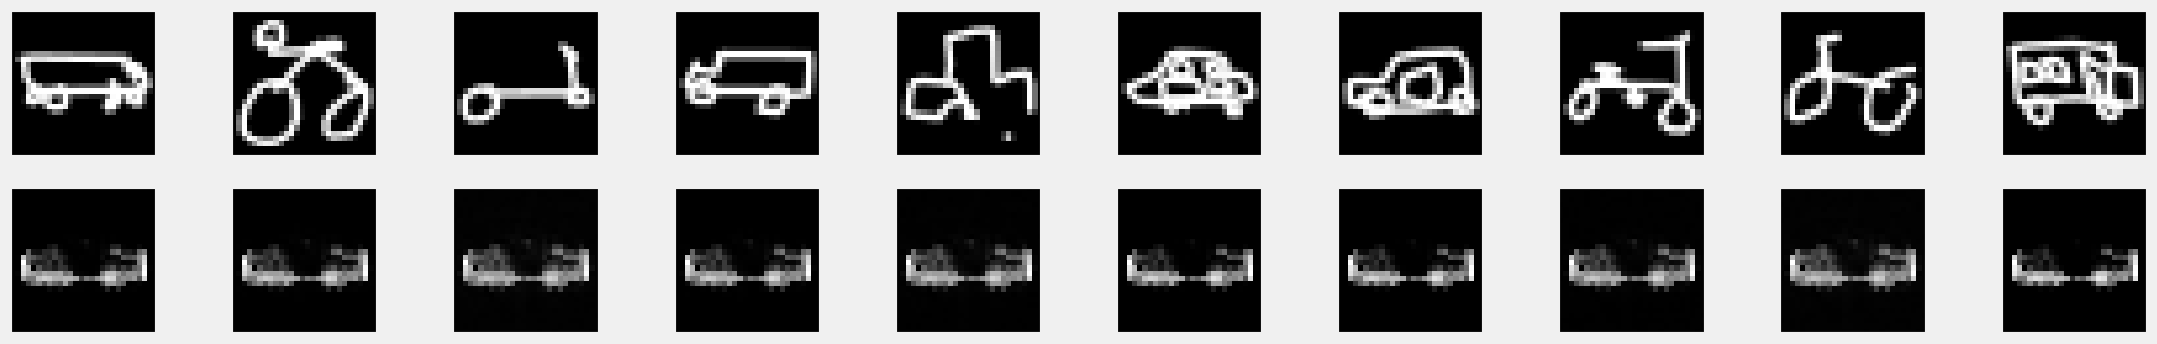

In [352]:
images, l = next(dataiter)
images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model2(images_flatten)
# prep images for display
images = images.numpy()
# output is resized into a batch of images
output = output.view(28, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
print(l)

In [296]:
cat

['Car', 'Bus', 'Biycle', 'Truck', 'Aircraft']

In [297]:
x = []
y = []
z = []
lb = []
dataiter = iter(test_loader)
for batch_no in range(testy.shape[0]//28):
  images, l = next(dataiter)
  images_flatten = images.view(images.size(0), -1)
  # get sample outputs
  output = model2(images_flatten)
  # prep images for display
  images = images.numpy()
  out = model2.encoder(images_flatten).detach().numpy()
  x = np.concatenate((out[:,0],x), axis=0)
  y = np.concatenate((out[:,1],y), axis=0)
  z = np.concatenate((out[:,2],z), axis=0)
  lb = np.concatenate((lb,l), axis=0)

In [298]:
lb = np.round(lb,0)

In [299]:
import pandas as pd
import plotly.express as px

# Sample DataFrame
data = {
    'x': x,
    'y': y,
    'z': z,
    'hue': lb
}
df = pd.DataFrame(data)

# Plotting the interactive 3D plot
fig = px.scatter_3d(df, x='x', y='y', z='z', color='hue')

# Show the plot
fig.show()

In [303]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Doodle/AE/file2.csv')

In [305]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Doodle/AE/file2.csv')

In [306]:
cat

['Car', 'Bus', 'Biycle', 'Truck', 'Aircraft']

In [307]:
import pickle

In [310]:
pickle.dump(model2.encoder, open('/content/drive/MyDrive/Colab Notebooks/data/Doodle/AE/encoder2.pkl', 'wb'))
pickle.dump(model2.decoder, open('/content/drive/MyDrive/Colab Notebooks/data/Doodle/AE/decoder2.pkl', 'wb'))

In [312]:
encoder_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/data/Doodle/AE/encoder2.pkl', 'rb'))
decoder_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/data/Doodle/AE/decoder2.pkl', 'rb'))

## Image Generation

In [313]:
generator_model = decoder_model

In [314]:
# dataiter = iter(test_loader)
# images, l = next(dataiter)
# images_flatten = images.view(images.size(0), -1)

# images = images.numpy()
# out = model2.encoder(images_flatten)
# print(out)
# img = model2.decoder(out).view(28, 1, 28, 28).detach().numpy()[0]
# plt.figure(figsize=(2,2))
# plt.imshow(img[0], cmap='gray')

In [315]:
car = df[df.hue == 0]
car_x, car_y, car_z = car.x.mean(), car.y.mean(), car.z.mean()
bicycle = df[df.hue == 2]
bicycle_x, bicycle_y, bicycle_z = bicycle.x.mean(), bicycle.y.mean(), bicycle.z.mean()

In [316]:
(car_x, car_y, car_z), (bicycle_x, bicycle_y, bicycle_z)

((-2.5156589487595347, -34.763821400145986, 4.053639321362795),
 (-2.1787272269212745, -31.817636850231057, 7.320913301662931))

In [317]:
import torch
import numpy as np
a = np.array([[car_x, car_y, car_z]])
inp = torch.from_numpy(a)
inp = inp.to(torch.float32)
inp

tensor([[ -2.5157, -34.7638,   4.0536]])

torch.Size([1, 784])


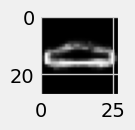

In [318]:
generated_image = generator_model(inp)
print(generated_image.size())
img = generated_image.view(inp.size(0),1,28,28).detach().numpy()[0]
plt.figure(figsize=(1,1))
plt.imshow(img[0], cmap='gray')